In [8]:
import sys
sys.path.append('../src')

import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

# Load data
X = scipy.io.loadmat('../data/data_train.mat')['data_train']
y = scipy.io.loadmat('../data/label_train.mat')['label_train'].flatten()

print(f"Data loaded: X {X.shape}, y {y.shape}")

# From Phase 3 results 
best_sigma_global = 6.5198
final_H = 9
final_selected = [79, 129, 201, 62, 115, 192, 89, 291, 300]

print("PHASE 3 RESULTS (from previous notebook)")
print(f"Global σ         : {best_sigma_global:.4f}")
print(f"H (neurons)      : {final_H}")
print(f"Selected neurons : {final_selected}")


Data loaded: X (301, 33), y (301,)
PHASE 3 RESULTS (from previous notebook)
Global σ         : 6.5198
H (neurons)      : 9
Selected neurons : [79, 129, 201, 62, 115, 192, 89, 291, 300]


In [9]:
selected_centers = X[final_selected]  # (9, 33)

# Compute P (number of neighbors to consider)
P = 2
print(f"P (neighbors)    : {P}")

# Compute pairwise distances between selected centers
D_centers = cdist(selected_centers, selected_centers, metric='euclidean')

# For each center, find P nearest neighbors (excluding itself)
sigma_refined = np.zeros(final_H)

for j in range(final_H):
    # Get distances from center j to all other centers
    distances = D_centers[j, :]
    
    # Set self-distance to inf to exclude it
    distances[j] = np.inf
    
    # Find P nearest neighbors
    nearest_P = np.partition(distances, P-1)[:P]
    
    # Sigma = mean distance to P nearest neighbors
    sigma_refined[j] = np.mean(nearest_P)


print("Per-Neuron Sigma Values:")
for j, (neuron_idx, sig) in enumerate(zip(final_selected, sigma_refined)):
    print(f"  Neuron {j+1} (sample {neuron_idx:3d}): σ = {sig:.4f}")


print("\nSTATISTICS:")
print(f"  Global σ (before)     : {best_sigma_global:.4f}")
print(f"  Mean refined σ        : {np.mean(sigma_refined):.4f}")
print(f"  Min refined σ         : {np.min(sigma_refined):.4f}")
print(f"  Max refined σ         : {np.max(sigma_refined):.4f}")


P (neighbors)    : 2
Per-Neuron Sigma Values:
  Neuron 1 (sample  79): σ = 3.1921
  Neuron 2 (sample 129): σ = 5.3217
  Neuron 3 (sample 201): σ = 7.2600
  Neuron 4 (sample  62): σ = 3.9186
  Neuron 5 (sample 115): σ = 11.2061
  Neuron 6 (sample 192): σ = 4.7398
  Neuron 7 (sample  89): σ = 6.0974
  Neuron 8 (sample 291): σ = 4.3694
  Neuron 9 (sample 300): σ = 3.4955

STATISTICS:
  Global σ (before)     : 6.5198
  Mean refined σ        : 5.5112
  Min refined σ         : 3.1921
  Max refined σ         : 11.2061


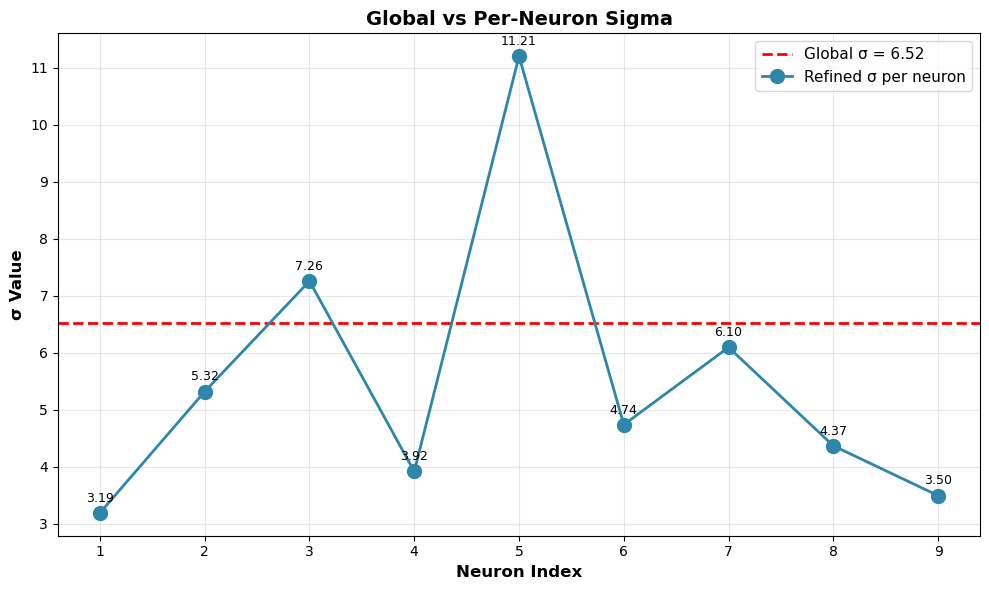

In [10]:
import os
os.makedirs('../plots', exist_ok=True)

fig, ax = plt.subplots(figsize=(10, 6))

# Global sigma baseline
ax.axhline(best_sigma_global, color='red', linestyle='--', 
           linewidth=2, label=f'Global σ = {best_sigma_global:.2f}')

# Refined sigmas per neuron
ax.plot(range(1, final_H + 1), sigma_refined, 
        marker='o', markersize=10, linewidth=2,
        color='#2E86AB', label='Refined σ per neuron')

# Annotate each point with the value
for i, sig in enumerate(sigma_refined):
    ax.annotate(f'{sig:.2f}',
                xy=(i+1, sig),
                xytext=(0, 8),
                textcoords='offset points',
                ha='center',
                fontsize=9)

ax.set_xlabel('Neuron Index', fontsize=12, fontweight='bold')
ax.set_ylabel('σ Value', fontsize=12, fontweight='bold')
ax.set_title('Global vs Per-Neuron Sigma', fontsize=14, fontweight='bold')
ax.set_xticks(range(1, final_H + 1))
ax.grid(alpha=0.3)
ax.legend(fontsize=11)

plt.tight_layout()
plt.savefig('../plots/sigma_refinement.png', dpi=300, bbox_inches='tight')
plt.show()


In [11]:
print("\nStep 1: Recomputing Φ with refined sigmas...")

N = X.shape[0]  # 301
H = final_H     # 9

Phi_final = np.zeros((N, H))

for j in range(H):
    center_j = X[final_selected[j]]  # (33,)
    sigma_j = sigma_refined[j]
    
    # Compute distances from all samples to this center
    distances = np.linalg.norm(X - center_j, axis=1)  # (301,)
    
    # Apply Gaussian RBF with this neuron's specific sigma
    Phi_final[:, j] = np.exp(- distances**2 / (2 * sigma_j**2))

print(f"  Φ shape: {Phi_final.shape}")
print(f"  Φ min:   {Phi_final.min():.4f}")
print(f"  Φ max:   {Phi_final.max():.4f}")
print(f"  Φ mean:  {Phi_final.mean():.4f}")


Step 1: Recomputing Φ with refined sigmas...
  Φ shape: (301, 9)
  Φ min:   0.0003
  Φ max:   1.0000
  Φ mean:  0.3861


In [12]:
# Step 2: Solve for output weights using least squares
print("\nStep 2: Solving for output weights W...")

# W = (Φ^T Φ)^(-1) Φ^T y
Phi_T = Phi_final.T
Phi_T_Phi = Phi_T @ Phi_final
Phi_T_y = Phi_T @ y

# Add small regularization for numerical stability
regularization = 1e-6
Phi_T_Phi_reg = Phi_T_Phi + regularization * np.eye(H)

# Solve
W = np.linalg.solve(Phi_T_Phi_reg, Phi_T_y)

print(f"  W shape: {W.shape}")
print("\n" + "-" * 60)
print("Output Weights:")
print("-" * 60)
for j in range(H):
    print(f"  w_{j+1} (neuron {final_selected[j]:3d}): {W[j]:+.4f}")
print("-" * 60)


Step 2: Solving for output weights W...
  W shape: (9,)

------------------------------------------------------------
Output Weights:
------------------------------------------------------------
  w_1 (neuron  79): +0.3184
  w_2 (neuron 129): +1.6451
  w_3 (neuron 201): +3.3211
  w_4 (neuron  62): +2.3867
  w_5 (neuron 115): -3.5946
  w_6 (neuron 192): -3.7461
  w_7 (neuron  89): +1.3932
  w_8 (neuron 291): +0.3842
  w_9 (neuron 300): +0.6995
------------------------------------------------------------


In [13]:

# Compute predictions on training data
y_train_pred_raw = Phi_final @ W
y_train_pred = np.sign(y_train_pred_raw)

# Handle zeros (assign to +1)
y_train_pred[y_train_pred == 0] = 1

# Compute accuracy
train_accuracy = np.mean(y_train_pred == y)

print(f"Training accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")

# Confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y, y_train_pred)

print("\nConfusion Matrix:")
print("                 Predicted")
print("               -1        +1")
print(f"Actual -1  [{cm[0,0]:4d}]    [{cm[0,1]:4d}]")
print(f"Actual +1  [{cm[1,0]:4d}]    [{cm[1,1]:4d}]")

# Per-class accuracy
acc_neg = cm[0,0] / (cm[0,0] + cm[0,1])
acc_pos = cm[1,1] / (cm[1,0] + cm[1,1])

print(f"\nClass -1 accuracy: {acc_neg:.4f}")
print(f"Class +1 accuracy: {acc_pos:.4f}")

Training accuracy: 0.9468 (94.68%)

Confusion Matrix:
                 Predicted
               -1        +1
Actual -1  [  95]    [  11]
Actual +1  [   5]    [ 190]

Class -1 accuracy: 0.8962
Class +1 accuracy: 0.9744


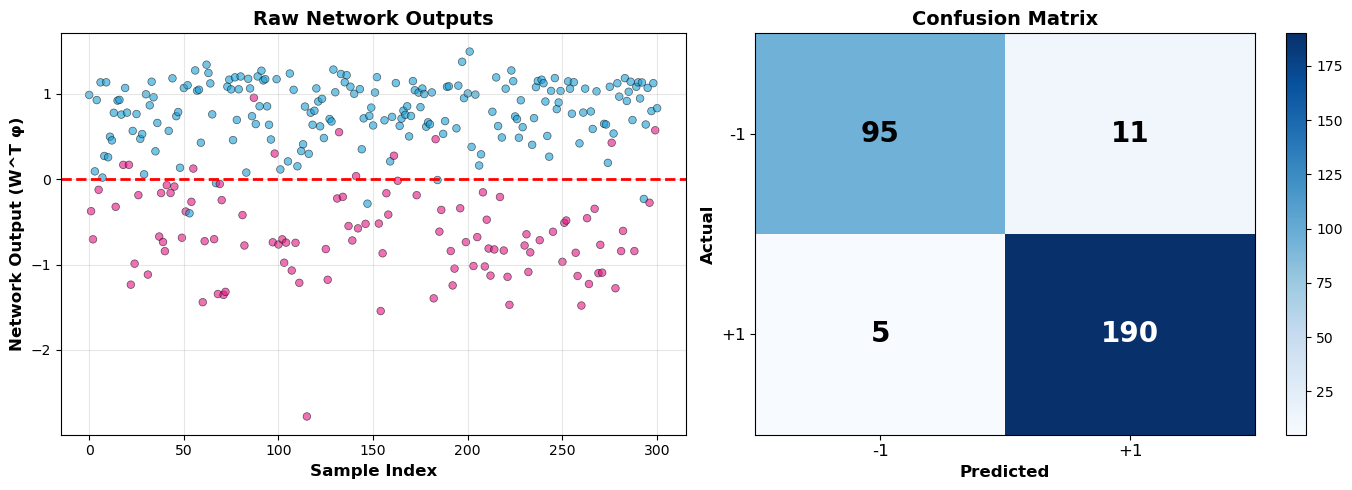

In [17]:
import os
os.makedirs('../plots', exist_ok=True)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Raw outputs
axes[0].scatter(range(len(y_train_pred_raw)), y_train_pred_raw,
               c=["#E11281" if label == -1 else "#179DD6" for label in y],
               alpha=0.6, s=30, edgecolors='black', linewidth=0.5)
axes[0].axhline(0, color='red', linestyle='--', linewidth=2, label='Decision boundary')
axes[0].set_xlabel('Sample Index', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Network Output (W^T φ)', fontsize=12, fontweight='bold')
axes[0].set_title('Raw Network Outputs', fontsize=14, fontweight='bold')
#axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot 2: Confusion matrix heatmap
im = axes[1].imshow(cm, cmap='Blues', aspect='auto')
axes[1].set_xticks([0, 1])
axes[1].set_yticks([0, 1])
axes[1].set_xticklabels(['-1', '+1'], fontsize=12)
axes[1].set_yticklabels(['-1', '+1'], fontsize=12)
axes[1].set_xlabel('Predicted', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Actual', fontsize=12, fontweight='bold')
axes[1].set_title('Confusion Matrix', fontsize=14, fontweight='bold')

# Add text annotations
for i in range(2):
    for j in range(2):
        text = axes[1].text(j, i, cm[i, j],
                          ha="center", va="center", 
                          color="white" if cm[i, j] > cm.max()/2 else "black",
                          fontsize=20, fontweight='bold')

plt.colorbar(im, ax=axes[1])
plt.tight_layout()
plt.savefig('../plots/training_performance.png', dpi=300, bbox_inches='tight')
plt.show()


In [19]:
print("Final RBF Network:")
print(f" H neurons       : {final_H}")
print(f" Selected centers: {final_selected}")
print(f" Per-neuron σ    : {sigma_refined}")
print(f" Output weights W: {W}")
print(f" Training accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")

Final RBF Network:
 H neurons       : 9
 Selected centers: [79, 129, 201, 62, 115, 192, 89, 291, 300]
 Per-neuron σ    : [ 3.19214981  5.32172426  7.2600029   3.9186115  11.20612224  4.73982264
  6.09735277  4.36944061  3.49549728]
 Output weights W: [ 0.31843685  1.64511092  3.32111063  2.38670609 -3.59455555 -3.74609518
  1.39322291  0.38423756  0.69952924]
 Training accuracy: 0.9468 (94.68%)
